# __[ LG Energy Solution ] <br><br>Anomaly Detection Part2: Convolutional Auto-Encoder__

# __<br>1. Data: MNIST Dataset__

- 데이터 description <br>
    - MNIST Dataset은 손글씨 데이터로 0 ~ 9에 해당하는 흑백 이미지로 구성되어 있다. <br><br>
- 변수 설명
    - 이미지: 28 x 28 x 1 차원의 이미지로 픽셀 값을 나타냄

<img src="https://i.imgur.com/Xo4PDvM.jpg" width="600">

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

### Step1. 데이터 불러오기

In [2]:
# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='./data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', 
                                          train=False, 
                                          transform=transforms.ToTensor())


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/Users/heejeongchoi/miniconda3/envs/dsba/lib/python3.6/site-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Step 2. Anomaly Detection 데이터 만들기 (normal: 1, abnormal: 8)

In [3]:
# train data: Class = 1인 train 데이터셋
train_dataset = [train_dataset.__getitem__(idx) for idx in range(len(train_dataset)) \
                 if train_dataset.__getitem__(idx)[1] == 1]

In [4]:
# test normal data: Class = 1인 test 데이터셋
test_normal_dataset = [test_dataset.__getitem__(idx) for idx in range(len(test_dataset)) \
                       if test_dataset.__getitem__(idx)[1] == 1]

In [5]:
# test abnormal data: Class = 8인 test 데이터셋
random.seed(42)
test_abnormal_dataset = [test_dataset.__getitem__(idx) for idx in range(len(test_dataset)) \
                         if test_dataset.__getitem__(idx)[1] == 8]

In [6]:
test_dataset = test_normal_dataset + test_abnormal_dataset

In [7]:
# test 데이터에 대하여 label이 1이면 normal, 나머지에 해당하면 abnormal에 해당하는 정답 생성
y_test = [False if label == 1 else True for _, label in test_dataset]

### Step 3. DataLoader 만들기 (Benchmark Dataset)

In [8]:
# hyper-parameter 설정
batch_size = 32

In [9]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

---

# __<br>2-2. Convolutional Auto-Encoder__

### Convolutional Auto-Encoder
>입력과 출력이 동일한 인공신경망 구조 <br>
>정상 데이터에 대한 학습이 충분히 되어 있을 경우 정상 데이터는 자기 자신을 잘 복원할 수 있지만, 이상치 제이터는 학습 기회가 적어 상대적으로 잘 복원하지 못할 것을 가정

<img src="https://i.imgur.com/9iZyuGm.jpg" width="700">

In [10]:
# hyper-parameter 설정
num_epochs = 20
learning_rate = 0.001

device = 'cpu'

### Step 1. 모델 구축

In [11]:
class ConvolutionalAutoEncoder(nn.Module):
    def __init__(self):
        super(ConvolutionalAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
          nn.Conv2d(1, 8, kernel_size=3),
          nn.ReLU(),
          nn.Conv2d(8, 16, kernel_size=3),
          nn.ReLU()
        )

        self.decoder = nn.Sequential(
          nn.ConvTranspose2d(16, 8, kernel_size=3),
          nn.ReLU(),
          nn.ConvTranspose2d(8, 1, kernel_size=3)
        )
    
    def forward(self, x):
        out = self.encoder(x)
        out = self.decoder(out)
        out = F.sigmoid(out)
        return out

In [12]:
cae_model = ConvolutionalAutoEncoder()

### Step 2. Train 데이터로 모델 학습

In [13]:
# model 학습
def train_model(data_loader, model, criterion, num_epochs, learning_rate, device):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    model.train()
    for epoch in range(num_epochs):
        for i, (x, _) in enumerate(data_loader):
            x = x.to(device)
            
            # Forward pass
            outputs = model(x)
            loss = criterion(outputs, x)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 50 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, len(data_loader), loss.item()))
    
    return model

In [14]:
cae_train_criterion = nn.MSELoss()
cae_model = train_model(train_loader, cae_model, cae_train_criterion, num_epochs, learning_rate, device)

/Users/heejeongchoi/miniconda3/envs/dsba/lib/python3.6/site-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch [1/20], Step [50/211], Loss: 0.0397
Epoch [1/20], Step [100/211], Loss: 0.0068
Epoch [1/20], Step [150/211], Loss: 0.0048
Epoch [1/20], Step [200/211], Loss: 0.0035
Epoch [2/20], Step [50/211], Loss: 0.0024
Epoch [2/20], Step [100/211], Loss: 0.0018
Epoch [2/20], Step [150/211], Loss: 0.0016
Epoch [2/20], Step [200/211], Loss: 0.0013
Epoch [3/20], Step [50/211], Loss: 0.0009
Epoch [3/20], Step [100/211], Loss: 0.0007
Epoch [3/20], Step [150/211], Loss: 0.0007
Epoch [3/20], Step [200/211], Loss: 0.0008
Epoch [4/20], Step [50/211], Loss: 0.0006
Epoch [4/20], Step [100/211], Loss: 0.0004
Epoch [4/20], Step [150/211], Loss: 0.0004
Epoch [4/20], Step [200/211], Loss: 0.0004
Epoch [5/20], Step [50/211], Loss: 0.0005
Epoch [5/20], Step [100/211], Loss: 0.0004
Epoch [5/20], Step [150/211], Loss: 0.0005
Epoch [5/20], Step [200/211], Loss: 0.0004
Epoch [6/20], Step [50/211], Loss: 0.0003
Epoch [6/20], Step [100/211], Loss: 0.0003
Epoch [6/20], Step [150/211], Loss: 0.0003
Epoch [6/20], Ste

### Step 3. 적합된 모델을 기반으로 train/test 데이터의 anomaly score 도출 (Inference)

In [15]:
# model inference
def inference_model(data_loader, model, criterion, device):
    model = model.to(device)
    
    model.eval()
    with torch.no_grad():
        infer_loss = []
        for i, (x, _) in enumerate(data_loader):
            x = x.to(device)
            
            # Forward pass
            output = model(x)
            loss = criterion(output, x)
            loss = loss.reshape(loss.shape[0], -1).mean(axis=1)

            infer_loss += list(loss.data.numpy())
    return infer_loss

In [16]:
# train 데이터에 대한 최종 결과 도출
cae_infer_criterion = nn.L1Loss(reduction='none')
cae_train_loss = inference_model(train_loader, cae_model, cae_infer_criterion, device)
cae_test_loss = inference_model(test_loader, cae_model, cae_infer_criterion, device)

/Users/heejeongchoi/miniconda3/envs/dsba/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/heejeongchoi/miniconda3/envs/dsba/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Test Data')

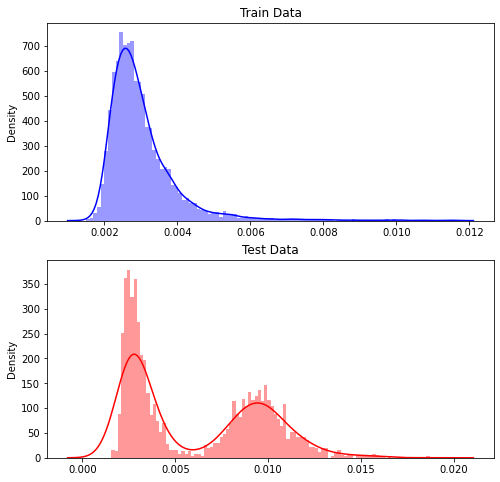

In [17]:
# train/test 데이터의 anomaly score 분포 시각화
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (8, 8))

sns.distplot(cae_train_loss, bins=100, kde=True, color='blue', ax=ax1)
sns.distplot(cae_test_loss, bins=100, kde=True, color='red', ax=ax2)
ax1.set_title("Train Data")
ax2.set_title("Test Data")

### Step 4. Threshold 탐색

In [18]:
# threshold 탐색
# score의 min ~ max 범위를 num_step개로 균등 분할한 threshold에 대하여 best threshold 탐색 
def search_best_threshold(score, y_true, num_step):
    best_f1 = 0
    best_threshold = None
    for threshold in np.linspace(min(score), max(score), num_step):
        y_pred = threshold < score

        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    print('Best threshold: ', round(best_threshold, 4))
    print('Best F1 Score:', round(best_f1, 4))
    return best_threshold

In [19]:
# best threshold 도출
cae_best_threshold = search_best_threshold(cae_test_loss, y_test, num_step=1000)

Best threshold:  0.0061
Best F1 Score: 0.9913


### Step 5. Best threshold를 기반으로 이상치 탐지 모형 평가

In [20]:
# FRR, FAR, F1 score 도출
def calculate_metric(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[True, False])
    tp, fn, fp, tn = cm.ravel()
    
    frr = fp / (fp + tn)
    far = fn / (fn + tp) 
    
    f1 = f1_score(y_true, y_pred)
    
    return frr, far, f1

In [21]:
# F1 Score: 0.9913
cae_y_test_pred = cae_best_threshold < cae_test_loss
frr, far, f1 = calculate_metric(y_test, cae_y_test_pred)

print("**  FRR: {}  |  FAR: {}  |  F1 Score: {}".format(round(frr, 4), round(far, 4), round(f1, 4)))

**  FRR: 0.0097  |  FAR: 0.0062  |  F1 Score: 0.9913


---